## Problem Statement:
#### Can the cases of West-Nile in Metro-Chicago be reduced (and the costs associated as a bonus) by strategically targeting the mosquito population in a preventative manner before they hit peak population?  How well can we train a model to balance correct predictions and misclassifications, and can its best results produce savings  - ROC AUC used to compare between models, weighted mispredictions used to evaluate unnecessary cost.

# Weather Part 2 - Data Exploration

   In this notebook, we explore the Chicago-weather dataset and prepare the data for use in the modeling/analysis.

## Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.neighbors import KernelDensity

import plotly
import plotly.graph_objs as go

%matplotlib inline

In [2]:
ps_spray = pd.read_csv('../1_Data/spray.csv')
rt_w_train = pd.read_csv('../1_Data/rt_weather_train.csv', index_col='Date')

We load data from the spray dataset and weather-training dataset.

## Simple EDA

Checking the shape of the latter data file that includes both mosquito/virus data and weather data and look at the head of the dataset.

In [3]:
print('The file is organized into',rt_w_train.shape[0], 'rows and', rt_w_train.shape[1], 'columns.')
rt_w_train.head().T

The file is organized into 8475 rows and 21 columns.


Date,2007-05-29,2007-05-29,2007-05-29,2007-05-29,2007-05-29
NumMosquitos,1.000000,1.000000,1.000000,1.000000,4.000000
WnvPresent,0.000000,0.000000,0.000000,0.000000,0.000000
Latitude,41.954690,41.954690,41.994991,41.974089,41.974089
Longitude,-87.800991,-87.800991,-87.769279,-87.824812,-87.824812
Tmax,80.000000,80.000000,80.000000,80.000000,80.000000
Tmin,57.000000,57.000000,57.000000,57.000000,57.000000
Tavg,69.000000,69.000000,69.000000,69.000000,69.000000
DewPoint,56.000000,56.000000,56.000000,56.000000,56.000000
WetBulb,61.000000,61.000000,61.000000,61.000000,61.000000
Sunrise,432.000000,432.000000,432.000000,432.000000,432.000000


The index will need to be treated as a date, so we will have to set the type as 'datetime64'.

In [4]:
rt_w_train.index = rt_w_train.index.astype('datetime64')
rt_w_train.index.year.unique()

Int64Index([2007, 2009, 2011, 2013], dtype='int64', name='Date')

In [5]:
max(rt_w_train.index)

Timestamp('2013-09-26 00:00:00')

One thing to note is that only odd-numbered years are represented, up to the end of September in 2013.

## Weather by Year
First we want to look at the average temperatures by year, then precipitation by year:

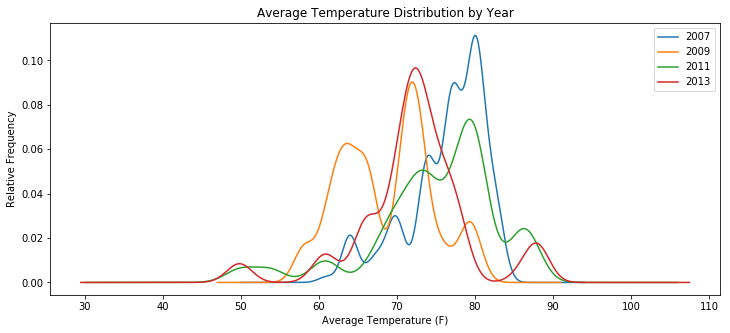

In [7]:
fig = plt.figure(figsize = (12,5))
rt_w_train.groupby(rt_w_train.index.year)['Tavg'].plot(kind = 'kde')
plt.xlabel("Average Temperature (F)")
plt.ylabel('Relative Frequency')
plt.title('Average Temperature Distribution by Year')
plt.legend();

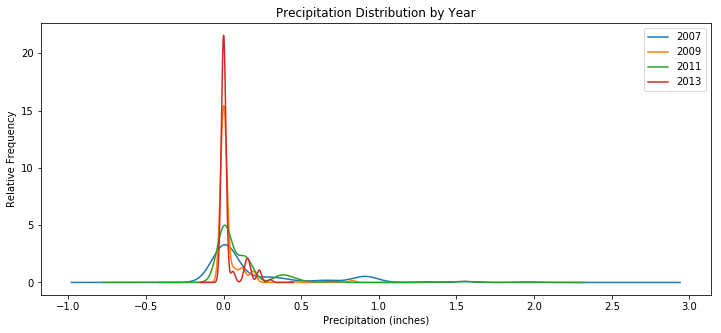

In [8]:
fig = plt.figure(figsize = (12,5))
rt_w_train.groupby(rt_w_train.index.year)['PrecipTotal'].plot(kind = 'kde')
plt.xlabel("Precipitation (inches)")
plt.ylabel('Relative Frequency')
plt.title('Precipitation Distribution by Year')
plt.legend();

We can see some pattern similarity above in alternate odd-years. We can next look into air pressure and wind speed

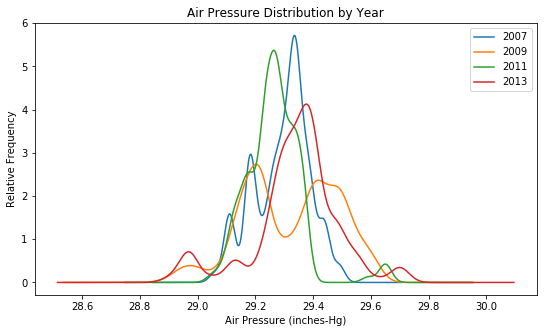

In [9]:
fig = plt.figure(figsize = (9,5))
rt_w_train.groupby(rt_w_train.index.year)['StnPressure'].plot(kind = 'kde')
plt.xlabel("Air Pressure (inches-Hg)")
plt.ylabel('Relative Frequency')
plt.title('Air Pressure Distribution by Year')
plt.legend();

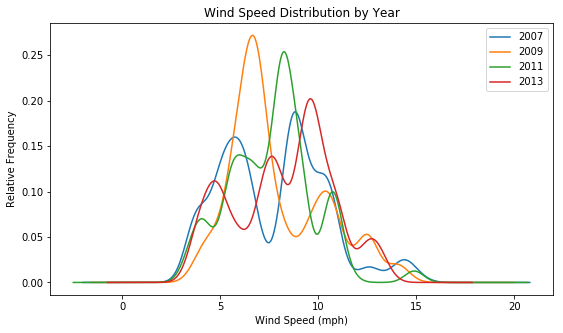

In [10]:
fig = plt.figure(figsize = (9,5))
rt_w_train.groupby(rt_w_train.index.year)['AvgSpeed'].plot(kind = 'kde')
plt.xlabel("Wind Speed (mph)")
plt.ylabel('Relative Frequency')
plt.title('Wind Speed Distribution by Year')
plt.legend();

For Air Pressure and Wind Speed, we see some broad seasonality/cyclicalness. Air Pressure shows a dip in year 2009 and peaks in years 2007 and 2013, while Wind Speed has peaks and dips in all years present.

## Weather vs Mosquitos

Next, we can take a look at possible relationships in weather conditions and mosquito concentration for years 2007 and 2011.

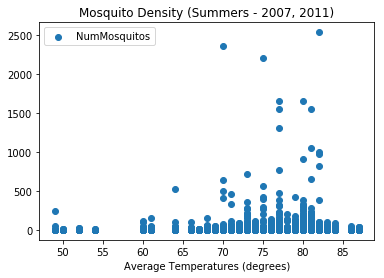

In [11]:
filter1 = (rt_w_train.index.year==2007) | (rt_w_train.index.year==2011)
plt.figure(); plt.scatter(rt_w_train[filter1]['Tavg'], rt_w_train[filter1]['NumMosquitos']); plt.xlabel("Average Temperatures (degrees)");plt.title('Mosquito Density (Summers - 2007, 2011)'); plt.legend()

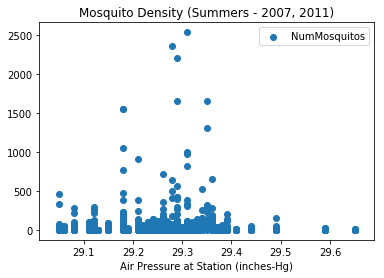

In [12]:
filter1 = (rt_w_train.index.year==2007) | (rt_w_train.index.year==2011)
plt.figure(); plt.scatter(rt_w_train[filter1]['StnPressure'], rt_w_train[filter1]['NumMosquitos']); plt.xlabel("Air Pressure at Station (inches-Hg)");plt.title('Mosquito Density (Summers - 2007, 2011)'); plt.legend()

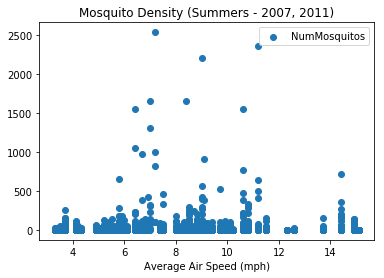

In [13]:
filter1 = (rt_w_train.index.year==2007) | (rt_w_train.index.year==2011)
plt.figure(); plt.scatter(rt_w_train[filter1]['AvgSpeed'], rt_w_train[filter1]['NumMosquitos']); plt.xlabel("Average Air Speed (mph)");plt.title('Mosquito Density (Summers - 2007, 2011)'); plt.legend()

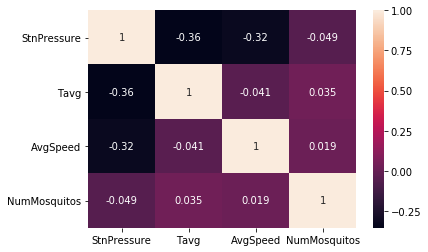

In [14]:
sns.heatmap(rt_w_train[['StnPressure', 
                        'Tavg',
                        'AvgSpeed',
                        'NumMosquitos']].corr(), annot=True)

There appears to be a positive relationship between mosquito concentration and average temperature/wind-speed, while the relationship between mosquito concentration and air-pressure is negative. However, all three weather dimensions have a weak correlation with mosquito concentration, if at all.

We can plot the weather patterns against the presence of West Nile Virus

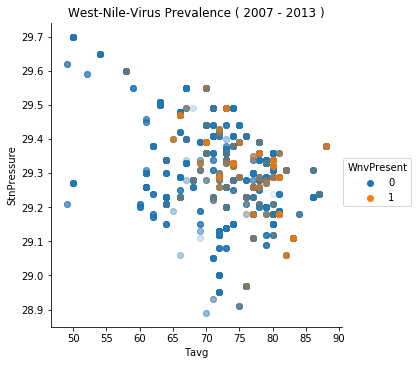

In [16]:
g = sns.lmplot(x='Tavg', y='StnPressure', data=rt_w_train, hue='WnvPresent', scatter_kws={'alpha':0.10}, fit_reg=False)
ax = plt.gca()
ax.set_title("West-Nile-Virus Prevalence ( 2007 - 2013 )")
for lh in g._legend.legendHandles:
    lh.set_alpha(1)

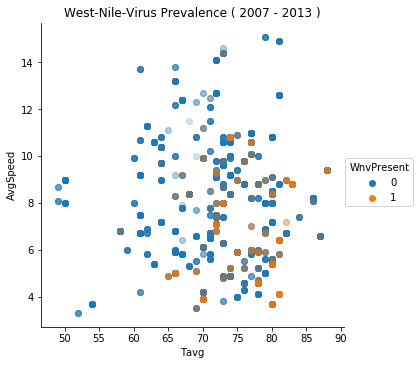

In [17]:
g = sns.lmplot(x='Tavg', y='AvgSpeed', data=rt_w_train, hue='WnvPresent', scatter_kws={'alpha':0.10}, fit_reg=False)
ax = plt.gca()
ax.set_title("West-Nile-Virus Prevalence ( 2007 - 2013 )")
for lh in g._legend.legendHandles:
    lh.set_alpha(1)

We see a weak relationship between weather conditions and the positive incidences of the virus.  The virus appears to be more prevalent at relatively higher temperatures and pressures and at relatively lower wind-speed conditions. 

## Spray Data

In [22]:
print('The file is organized into',ps_spray.shape[0], 'rows and', ps_spray.shape[1], 'columns.')
print(ps_spray.isnull().sum().sum())
ps_spray.head().T

The file is organized into 14835 rows and 3 columns.
0


Date,2011-08-29 00:00:00,2011-08-29 00:00:00,2011-08-29 00:00:00,2011-08-29 00:00:00,2011-08-29 00:00:00
Time,6:56:58 PM,6:57:08 PM,6:57:18 PM,6:57:28 PM,6:57:38 PM
Latitude,42.3916,42.3913,42.391,42.3906,42.3904
Longitude,-88.0892,-88.0892,-88.0892,-88.0892,-88.0889


There are only 4 columns in this dataset:
- The date can be used to merge with the training data if need be. 
- Time is worth noting that the spray occurs after 6 p.m., but otherwise does not seem necessary. I would drop this column if we decide to use this dataset.
- Latitude/Longitude - It would be interesting to try and overlap the spray locations with the locations in the training data. However, one concern would be the accuracy of the locations (re: address accuracy column in the train data) and the number of decimals throwing off the consistency.

Setting our index as DateTime-type

In [19]:
ps_spray.set_index('Date', inplace=True)
ps_spray.index = pd.to_datetime(ps_spray.index)

In [20]:
print(max(ps_spray.index))
ps_spray.index.year.unique()

2013-09-05 00:00:00


Int64Index([2011, 2013], dtype='int64', name='Date')

We can see that we have two years' worth of spray data, ending at the beginning of September-2013.

## Plotting virus incidence and spraying by year

Note - the code for the visualizations above and below are available courtesy of James Hampton.

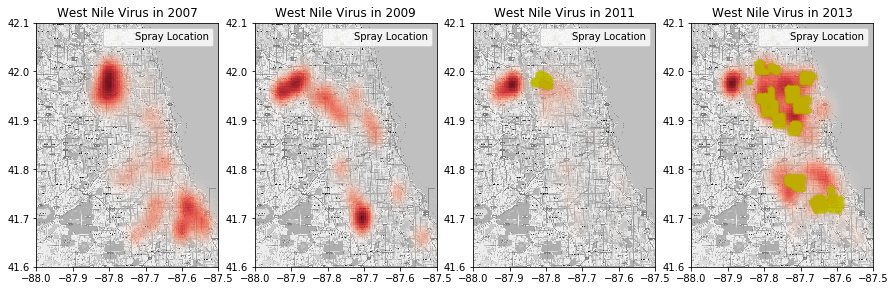

In [24]:
mapdata = np.loadtxt("../1_Data/mapdata_copyright_openstreetmap_contributors.txt")

fig, axes =plt.subplots(figsize = (15,5),nrows = 1, ncols = 4)

for idx, year in enumerate(rt_w_train.index.year.unique()):

    # Show map in desired lat, long range
    axes[idx].imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
           aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])
    
    # Scatter plot for trap locations 
    traps = rt_w_train[['Longitude', 'Latitude']].drop_duplicates().values
    
    # Plot a density map of West-Nile-Virus sighting
    alphas = plt.cm.Reds
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = rt_w_train[['Longitude','Latitude']][(rt_w_train['WnvPresent'] == 1) & (rt_w_train.index.year== year)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axes[idx].imshow(zv,
               origin = 'lower',
              cmap = alphas,
              extent = (-88, -87.5, 41.6, 42.1),
              aspect = mapdata.shape[0]*1.0/mapdata.shape[1])
    
    # Scatter plot for spray locations (removing outliers far away from the rest of the traps)
    current = ps_spray[ps_spray.index.year==year]
    axes[idx].scatter(current[current['Longitude']>=-88]['Longitude'], 
                      current[current['Latitude']<=42.1]['Latitude'], 
                      marker = '*', 
                      color = 'y', 
                      label = "Spray Location", 
                      alpha=0.05)
    # Labels
    axes[idx].set_title(f"West Nile Virus in {year}")
    axes[idx].legend();

In plotting this spatial data, we found 95 rows in 2011 with locations beyond the 42.1-degree parallel of the mapped area (identified below).

In [ ]:
len(ps_spray[(ps_spray.index.year==2011)&(ps_spray['Latitude']>=42.1)])

## Plotting pattern and timing of the spraying

Starting with 2011, we can do this with snapshots of West-Nile-virus presence from July through September.

In [25]:
rt_w_t_2011 = rt_w_train[(rt_w_train.index.year==2011) & (rt_w_train.index.month!=6)]
ps_spray_2011 = ps_spray[ps_spray.index.year==2011]

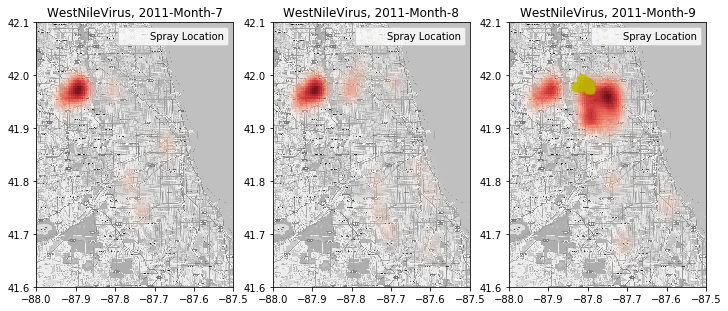

In [27]:
mapdata = np.loadtxt("../1_Data/mapdata_copyright_openstreetmap_contributors.txt")

fig, axes =plt.subplots(figsize = (12,5),nrows = 1, ncols = 3)

for idx, month in enumerate(rt_w_t_2011.index.month.unique()):

    # Show map in desired lat, long range
    axes[idx].imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
           aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])
    
    # Scatter plot for trap locations 
    traps = rt_w_t_2011[['Longitude', 'Latitude']].drop_duplicates().values
    
    # Plot a density map of West-Nile-Virus sighting
    alphas = plt.cm.Reds
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = rt_w_t_2011[['Longitude','Latitude']][(rt_w_t_2011['WnvPresent'] == 1) & (rt_w_t_2011.index.month==month)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axes[idx].imshow(zv,
               origin = 'lower',
              cmap = alphas,
              extent = (-88, -87.5, 41.6, 42.1),
              aspect = mapdata.shape[0]*1.0/mapdata.shape[1])
    
    # Scatter plot for spray locations (removing outliers far away from the rest of the traps)
    current = ps_spray_2011[ps_spray_2011.index.month==month]
    axes[idx].scatter(current[current['Longitude']>=-88]['Longitude'], 
                      current[current['Latitude']<=42.1]['Latitude'], 
                      marker = '*', 
                      color = 'y', 
                      label = "Spray Location", 
                      alpha=0.05)
    # Labels
    axes[idx].set_title(f"WestNileVirus, 2011-Month-{month}")
    axes[idx].legend();

In [28]:
rt_w_t_2013 = rt_w_train[(rt_w_train.index.year==2013)]
ps_spray_2013 = ps_spray[ps_spray.index.year==2013]

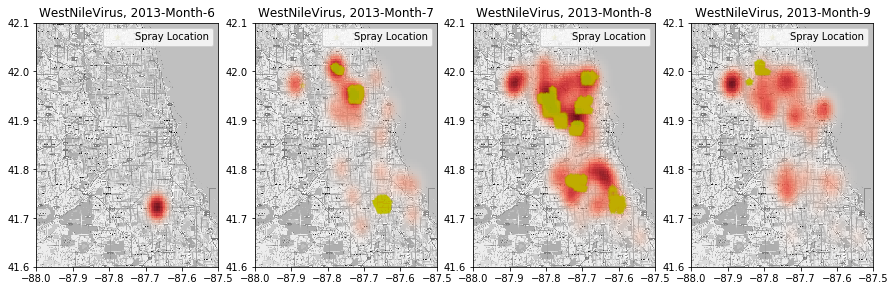

In [29]:
mapdata = np.loadtxt("../1_Data/mapdata_copyright_openstreetmap_contributors.txt")

fig, axes =plt.subplots(figsize = (15,5),nrows = 1, ncols = 4)  # Four months of data in 2013.

for idx, month in enumerate(rt_w_t_2013.index.month.unique()):  # Loop through each month.

    # 1. Show map in desired lat, long range
    axes[idx].imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
           aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])
    
    # 2. Scatter plot for distinct trap locations 
    traps = rt_w_t_2013[['Longitude', 'Latitude']].drop_duplicates().values
    
    # 3. Plot a density map of West-Nile-Virus presnce
    alphas = plt.cm.Reds
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = rt_w_t_2013[['Longitude','Latitude']][(rt_w_t_2013['WnvPresent'] == 1) & (rt_w_t_2013.index.month==month)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axes[idx].imshow(zv,
               origin = 'lower',
              cmap = alphas,
              extent = (-88, -87.5, 41.6, 42.1),
              aspect = mapdata.shape[0]*1.0/mapdata.shape[1])
    
    # 4. Scatter plot for spray locations (limited to spraying south of 42.1-degrees latitude)
    current = ps_spray_2013[ps_spray_2013.index.month==month]
    axes[idx].scatter(current[current['Longitude']>=-88]['Longitude'], 
                      current[current['Latitude']<=42.1]['Latitude'], 
                      marker = '*', 
                      color = 'y', 
                      label = "Spray Location", 
                      alpha=0.05)
    # Subplot labels
    axes[idx].set_title(f"WestNileVirus, 2013-Month-{month}")
    axes[idx].legend();

Looking at these plots, it appears that the spraying in the south of Chicago in July-2013 was in response to an incidence of the virus in June.  There would understandably be a lead-time between collecting traps and determining the presence of the virus, as well as scheduling the spraying. This validates our assumption that the spraying is relatively ineffective at preventing West Nile Virus, and instead is currently (as of 2013) being used reactively. We can use this as a basis to recommend our predictions and suggested solutions.

We can take a closer look at July-2013, then August, to check if this lead-time applies there

In [30]:
rt_w_t_2013_July = rt_w_train[(rt_w_train.index.year==2013) & (rt_w_train.index.month==7)]
ps_spray_2013_July = ps_spray[(ps_spray.index.year==2013) & (ps_spray.index.month==7)]

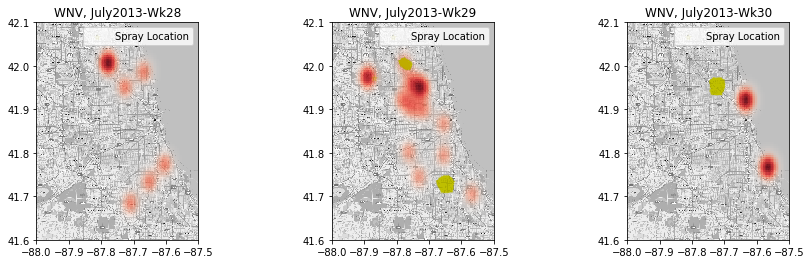

In [32]:
mapdata = np.loadtxt("../1_Data/mapdata_copyright_openstreetmap_contributors.txt")

fig, axes =plt.subplots(figsize = (15,4),nrows = 1, ncols = 3)  # There are 3 separate weeks in August-2013.

for idx, week in enumerate(rt_w_t_2013_July.index.week.unique()):   # Loop through each weekly period.

    # 1. Show map in desired lat, long range
    axes[idx].imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
           aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])
    
    # 2. Scatter plot for distinct trap locations:
    traps = rt_w_t_2013_July[['Longitude', 'Latitude']].drop_duplicates().values
    
    # 3. Plot a density map of West-Nile-Virus presence
    alphas = plt.cm.Reds
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = rt_w_t_2013_July[['Longitude','Latitude']][(rt_w_t_2013_July['WnvPresent'] == 1) & (rt_w_t_2013_July.index.week==week)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axes[idx].imshow(zv,
               origin = 'lower',
              cmap = alphas,
              extent = (-88, -87.5, 41.6, 42.1),
              aspect = mapdata.shape[0]*1.0/mapdata.shape[1])
    
    # 4. Scatter plot for spray locations (limited to spraying south of 42.1-degrees latitude)
    current = ps_spray_2013_July[ps_spray_2013_July.index.week==week]
    axes[idx].scatter(current[current['Longitude']>=-88]['Longitude'], 
                      current[current['Latitude']<=42.1]['Latitude'], 
                      marker = '*', 
                      color = 'y', 
                      label = "Spray Location", 
                      alpha=0.05)
    # Subplot labels:
    axes[idx].set_title(f"WNV, July2013-Wk{week}")
    axes[idx].legend();

Once again, we see the spraying starting in mid-July in response to a presence of the virus in the south of Chicago in June, as well as a response to its presence near the airport in Week-28.  In Week-30 there is a clear lag due to the presence in the upper-center part of the mapped area. This further validates our approach.

In [33]:
rt_w_t_2013_Aug = rt_w_train[(rt_w_train.index.year==2013) & (rt_w_train.index.month==8)]
ps_spray_2013_Aug = ps_spray[(ps_spray.index.year==2013) & (ps_spray.index.month==8)]

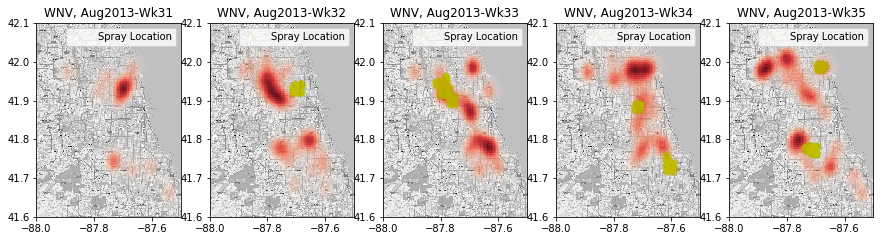

In [35]:
mapdata = np.loadtxt("../1_Data/mapdata_copyright_openstreetmap_contributors.txt")

fig, axes =plt.subplots(figsize = (15,4),nrows = 1, ncols = 5)  # There are 5 separate weeks in August-2013.

for idx, week in enumerate(rt_w_t_2013_Aug.index.week.unique()):   # Loop through each weekly period.

    # 1. Show map in desired lat, long range
    axes[idx].imshow(mapdata, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
           aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1])
    
    # 2. Scatter plot for distinct trap locations:
    traps = rt_w_t_2013_Aug[['Longitude', 'Latitude']].drop_duplicates().values
    
    # 3. Plot a density map of West-Nile-Virus presence
    alphas = plt.cm.Reds
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = rt_w_t_2013_Aug[['Longitude','Latitude']][(rt_w_t_2013_Aug['WnvPresent'] == 1) & (rt_w_t_2013_Aug.index.week==week)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axes[idx].imshow(zv,
               origin = 'lower',
              cmap = alphas,
              extent = (-88, -87.5, 41.6, 42.1),
              aspect = mapdata.shape[0]*1.0/mapdata.shape[1])
    
    # 4. Scatter plot for spray locations (limited to spraying south of 42.1-degrees latitude)
    current = ps_spray_2013_Aug[ps_spray_2013_Aug.index.week==week]
    axes[idx].scatter(current[current['Longitude']>=-88]['Longitude'], 
                      current[current['Latitude']<=42.1]['Latitude'], 
                      marker = '*', 
                      color = 'y', 
                      label = "Spray Location", 
                      alpha=0.05)
    # Subplot labels:
    axes[idx].set_title(f"WNV, Aug2013-Wk{week}")
    axes[idx].legend();

We see a lag in the spraying by a week from Week-31 to Week-34.  In Week-35, the spraying in the south part of Chicago may have been closer to anticipatory.

## A (brief) conclusion

The weather relationships in our data confirmed cyclical patterns, which make sense given that weather is seasonal (in fact, that's the very definition of seasonality). Although seemingly a fruitless exploration, the visualization helps us with domain knowledge in roughly what the seasonality looks like by month in Chicago. 

We were also able to see the relationship of weather conditions to the concentration of mosquitos and the presence of the virus, again with the assumption that certain weather conditions will lead to a higher likelihood of WNV than others.

The spray dataset only spans 2 years and is significantly smaller in rows than the training data. It is questionable whether this data will be of any use in the actual modeling, but does provide value in confirming our assumption that the sprays currently being conducted (again, as of 2013) are relatively ineffectual on stopping WNV spread before it occurs, as they are largely reactionary.

With a better understanding of the feature and spatial relationships, we are able to plan and design our modeling strategies.